In [1]:
!pip install numpy==1.23.5 sweetviz

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import lightgbm as lgbm
import sweetviz as sv
from google.colab import drive, output
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, precision_recall_curve, precision_score, recall_score, roc_auc_score, roc_curve, auc, confusion_matrix
)
from sklearn.model_selection import train_test_split, StratifiedGroupKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from functools import partialmethod

Der Großteil des Codes wurde aufgrund des Zeitmangels auf Anforderung primär AI-assisted erstellt und anschließend bei Bedarf modifiziert.

# Aufgabenstellung

Anwendungsfall:
Vorhersage des Zufriedenheitsscores (NPS)

Durchführung
- Datenexploration
- Modellauswahl und dementsprechende Vorverarbeitung
- Modelltraining
- Modellevaluation und Analyse der Ergebnisse

# Funktionen

In [3]:
def stratified_group_split(X, y, groups, test_size=0.3, random_state=42):
    """
    Führt einen stratifizierten Split durch, wobei alle Instanzen mit der gleichen `group`
    (z. B. `app_id`) entweder im Trainings- oder Testset landen.
    """
    # Berechnung der Anzahl an Splits basierend auf dem Verhältnis
    n_splits = int(1 / test_size)

    # StratifiedGroupKFold-Objekt erstellen
    sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # Ersten Split nehmen (es gibt nur einen in diesem Fall)
    for train_idx, test_idx in sgkf.split(X, y, groups):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        break

    return X_train, X_test, y_train, y_test

In [4]:
def stratified_group_cv(X, y, groups, n_splits=5, random_state=42):
    """
    StratifiedGroupKFold: Stratifiziert nach Zielvariable y und achtet auf Gruppen (z. B. app_id),
    sodass Gruppen nicht zwischen Train und Test aufgeteilt werden.
    """
    sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    return sgkf.split(X, y, groups)

In [5]:
def evaluate_model(model, X_train, y_train, X_test, y_test, threshold=0.17):
    """
    Bewertet ein Klassifikationsmodell auf Trainings- und Testdaten anhand verschiedener Metriken.
    Gibt die wichtigsten Metriken (Accuracy, Precision, Recall, F1-Score) in Tabellenform aus.
    """

    results = {}
    metric_table = {}

    for dataset, X, y in [('Train', X_train, y_train), ('Test', X_test, y_test)]:
        y_pred = model.predict(X)
        y_proba = model.predict_proba(X)[:, 1]
        y_pred_adjusted = (y_proba >= threshold).astype(int)

        # Metriken berechnen
        acc = accuracy_score(y, y_pred_adjusted)
        prec = precision_score(y, y_pred_adjusted)
        rec = recall_score(y, y_pred_adjusted)
        f1 = f1_score(y, y_pred_adjusted)

        # In Dictionary schreiben
        metric_table[dataset] = {
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1-Score": f1
        }

        # Weitere Ergebnisse speichern
        results[f'ROC-AUC_{dataset}'] = roc_auc_score(y, y_proba)
        precisions, recalls, thresholds_pr = precision_recall_curve(y, y_proba)
        results[f'PR-AUC_{dataset}'] = auc(recalls, precisions)
        results[f'Precision_{dataset}'], results[f'Recall_{dataset}'], results[f'Thresholds_PR_{dataset}'] = precisions, recalls, thresholds_pr

        fpr, tpr, thresholds_roc = roc_curve(y, y_proba)
        results[f'ROC_{dataset}'] = (fpr, tpr, thresholds_roc)

        cm = confusion_matrix(y, y_pred_adjusted)
        cm_normalized = confusion_matrix(y, y_pred_adjusted, normalize='all')
        results[f'Confusion_Matrix_{dataset}'] = cm
        results[f'Confusion_Matrix_Normalized_{dataset}'] = cm_normalized

    # Tabelle erzeugen und ausgeben
    df_metrics = pd.DataFrame(metric_table).T.round(4)
    print(f"Modellmetriken Train vs. Test für den Threshold {threshold}:")
    print(df_metrics)

    return results

In [6]:
def plot_roc_pr_curves(results, threshold=0.17):
    plt.figure(figsize=(12, 5))

    # ROC-Kurve
    plt.subplot(1, 2, 1)
    plt.plot(results['ROC_Train'][0], results['ROC_Train'][1], label=f'Train ROC-AUC = {results["ROC-AUC_Train"]:.2f}', color='blue')
    plt.plot(results['ROC_Test'][0], results['ROC_Test'][1], label=f'Test ROC-AUC = {results["ROC-AUC_Test"]:.2f}', color='red')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-Kurve')
    plt.legend()

    # Threshold-Punkt auf der ROC-Kurve markieren
    for dataset in ['Train', 'Test']:
        fpr, tpr, thresholds_roc = results[f'ROC_{dataset}']
        idx = np.argmin(np.abs(thresholds_roc - threshold))
        plt.scatter(fpr[idx], tpr[idx], color='black', marker='o', label=f'{dataset} Threshold')

    # Precision-Recall-Kurve
    plt.subplot(1, 2, 2)
    plt.plot(results['Recall_Train'], results['Precision_Train'], label=f'Train PR-AUC = {results["PR-AUC_Train"]:.2f}', color='blue')
    plt.plot(results['Recall_Test'], results['Precision_Test'], label=f'Test PR-AUC = {results["PR-AUC_Test"]:.2f}', color='red')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim(0, 1)  # Y-Achse auf [0, 1] skalieren
    plt.title('Precision-Recall-Kurve')
    plt.legend()

    # Threshold-Punkt auf der Precision-Recall-Kurve markieren
    for dataset in ['Train', 'Test']:
        precisions, recalls, thresholds_pr = results[f'Precision_{dataset}'], results[f'Recall_{dataset}'], results[f'Thresholds_PR_{dataset}']
        idx = np.argmin(np.abs(thresholds_pr - threshold))
        plt.scatter(recalls[idx], precisions[idx], color='black', marker='o', label=f'{dataset} Threshold')

    plt.tight_layout()
    plt.show()

In [7]:
def plot_confusion_matrices(results):
    """
    Visualisiert die Confusion Matrices (roh und normalisiert) für Trainings- und Testdaten
    in einem 2x2-Grid mit Hilfe von Seaborn Heatmaps.

    Erwartet ein `results`-Dictionary, wie es von `evaluate_model()` zurückgegeben wird.
    """

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    for i, dataset in enumerate(['Train', 'Test']):
        cm = results[f'Confusion_Matrix_{dataset}']
        cm_normalized = results[f'Confusion_Matrix_Normalized_{dataset}']

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativ', 'Positiv'], yticklabels=['Negativ', 'Positiv'], ax=axes[i, 0])
        axes[i, 0].set_title(f'Confusion Matrix - {dataset} (Nicht normalisiert)')
        axes[i, 0].set_xlabel('Vorhergesagte Klasse')
        axes[i, 0].set_ylabel('Tatsächliche Klasse')

        sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Negativ', 'Positiv'], yticklabels=['Negativ', 'Positiv'], ax=axes[i, 1])
        axes[i, 1].set_title(f'Confusion Matrix - {dataset} (Normalisiert)')
        axes[i, 1].set_xlabel('Vorhergesagte Klasse')
        axes[i, 1].set_ylabel('Tatsächliche Klasse')

    plt.tight_layout()
    plt.show()

# Datenimport

In [8]:
# Lade die Daten aus der csv
df = pd.read_csv("bewerber_aufgabe_interhyp.csv", index_col=[0])

# Datenexploration

In [9]:
df

,app_id,NPS,response_content,response_unhappy,response_friendly,APL_SEX,APL_BIRTHYEAR,APL_FREEZE_AVAILABLE_INCOME
0,18683842,-100,85,20,85,M,1969-01-01 00:00:00,3408.36
1,21406925,100,85,1,85,M,1985-01-01 00:00:00,2519.00
2,21406925,100,85,1,85,F,1988-01-01 00:00:00,1400.00
3,100524024,100,75,20,85,M,1983-01-01 00:00:00,3500.00
4,19866647,100,85,0,85,M,1987-01-01 00:00:00,4264.67
...,...,...,...,...,...,...,...,...
1826,9866614,100,85,20,85,M,1955-01-01 00:00:00,2873.00
1827,9866614,100,85,20,85,F,1950-01-01 00:00:00,2600.00
1828,21383404,100,45,85,65,M,1962-01-01 00:00:00,1462.89
1829,21383404,100,45,85,65,F,1961-01-01 00:00:00,2755.00


Das Geburtsjahr wird in das Alter umgewandelt, sodass man dieses zunächst besser analysieren und später auch sinnvoll beim Modelltraining verwenden kann. Die ursprüngliche Spalte wird anschließend entfernt.

In [10]:
# Umwandlung in ein datetime-Format
df["APL_BIRTHYEAR"] = pd.to_datetime(df["APL_BIRTHYEAR"], errors="coerce")

# Aktuelles Jahr bestimmen
current_year = pd.Timestamp.now().year

# Alter berechnen (fehlende Werte bleiben erhalten)
df["AGE"] = df["APL_BIRTHYEAR"].apply(lambda x: current_year - x.year if pd.notnull(x) else None)

# APL_BIRTHYEAR entfernen
df = df.drop(columns='APL_BIRTHYEAR')

In [11]:
df.AGE

,AGE
0,56.0
1,40.0
2,37.0
3,42.0
4,38.0
...,...
1826,70.0
1827,75.0
1828,63.0
1829,64.0


Es gibt mehrere Möglichkeiten für die spätere Lösung der Klassifikationsvorhersage:


1.   Binärisierung der Zielvariable und Einsatz eines binären Classifiers
2.   Einsatz eines Multiclass Classifiers
3.   Einsatz einer Regression und anschließende binäre Umwandlung bei einem festgelegten Threshold

Im Rahmen dieses Notebooks wird Variante 1 verwendet, da dies in der Kombination von Umsetzbarkeit und Interpretabilität der Features auf die Vorhersage am besten erscheint.

Da der ökonomische Mehrwert vorrangig darin liegen sollte, unzufriedene Kunden möglichst früh zu identifizieren, werden alle Kunden mit einem NPS-Score von 0 oder weniger in die positive Klasse einsortiert. Alle Kunden mit einem NPS-Score von 1 oder höher kommen in die negative Klasse.



In [12]:
# Überblick über die Zielvariable
df.NPS.value_counts()

,count
NPS,
100,1523
0,204
-100,102
50,2


In [13]:
# Binärisierung der Zielvariable - Ökonomisch Relevant sind nicht zufriedene Kunden, daher werden alle Kunden mit einem NPS-Score von 0 oder weniger in die positive Klasse einsortiert
df["NPS_binary"] = (df["NPS"] < 1).astype(int)

In [14]:
# Die neu gebildete Zielvariable ist recht stark imbalanced
df.NPS_binary.value_counts()

,count
NPS_binary,
0,1525
1,306


Anschließend sollen zunächst auf einem höheren Level eine möglichst automatisierte EDA durchgeführt werden, um anschließend Auffälligkeiten nochmals gezielt tieferzulegen. Der Sweetviz Report wird als html exportiert und ebenfalls zur Verfügung gestellt.

In [15]:
# Einblick in die numerischen Features des Datensatzes
df.describe()

,app_id,NPS,response_content,response_unhappy,response_friendly,APL_FREEZE_AVAILABLE_INCOME,AGE,NPS_binary
count,1.831000e+03,1831.00000,1831.000000,1831.000000,1831.000000,1811.000000,1751.000000,1831.000000
mean,4.757146e+07,77.66248,75.314036,16.897870,84.451120,3403.577338,47.629926,0.167122
std,3.984973e+07,53.36438,32.764639,22.966403,4.932516,4436.948905,11.591677,0.373186
min,1.687072e+06,-100.00000,-100.000000,-100.000000,45.000000,-1742.000000,24.000000,0.000000
25%,1.877274e+07,100.00000,85.000000,5.000000,85.000000,1920.480000,39.000000,0.000000
50%,2.144221e+07,100.00000,85.000000,15.000000,85.000000,2859.670000,45.000000,0.000000
75%,1.004456e+08,100.00000,85.000000,20.000000,85.000000,4107.915000,55.000000,0.000000
max,1.020104e+08,100.00000,100.000000,95.000000,95.000000,150000.000000,97.000000,1.000000


In [16]:
# Feature-Konfiguration für Sweetviz
feature_config = sv.FeatureConfig(
    force_cat=["APL_SEX"],  # Manuelle Definition der kategorischen Features
    force_num=["app_id", "NPS", "response_content", "response_unhappy", "response_friendly", "APL_FREEZE_AVAILABLE_INCOME", "AGE"]    # Manuelle Definition der numerischen Features
)

# Automatische Datenanalyse
report = sv.analyze(df, target_feat='NPS_binary', feat_cfg=feature_config)

# Report anzeigen
report.show_html("sweetviz_report.html")

                                             |          | [  0%]   00:00 -> (? left)

Report sweetviz_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## SweetViz Ergebnisse



**Allgemeine Informationen:**

*  1.831 Samples (recht wenige)

*  app_id besitzt doppelte Einträge. Da ich davon ausgehe, dass dies eine Art Kundennummer ist, muss bei train-test-splits darauf geachtet werden, dass jede app_id entweder nur in train oder nur in test landet, um Target Leakage zu vermeiden.

*  Potenzielle Ausreißer bei Alter. Es ist aber auch nicht unmöglich, dass ein 97-Jähriger noch eine Baufinanzierung abschließt, daher werden alle Werte im Dataframe behalten. Man könnte auch clippen oder Ähnliches. Dies wird aber erstmal nicht getan.

*  82 mal 0 (€) Einkommen bei APL_FREEZE_AVAILABLE_INCOME. Dies deutet schon stark auf einen Datenfehler hin und sollte fachlich geprüft werden. Es treten auch negative Einkommen auf, dies sollte ebenfalls fachlich geprüft werden. Zusätzlich stark rechtsschiefe Verteilung mit Einkommen bis 150k (€).
___
**Datenqualität:**

Imbalanced Dataset: NPS-Score von 0 oder niedriger bei 17% (Insgesamt 306 Samples)

*   Mögliche Auswirkung: Modell sagt bevorzugt Mehrheitsklasse (Positive Zufriedenheit) voraus.
*   Mögliche Lösungen: Undersampling, Oversampling, class_weight=balanced
*   Verwendete Lösung: Keine Gewichtung oder Data Sampling (Verzerrt Interpretierbarkeit der Wahrscheinlichkeiten), sondern vorwiegend Analyse der ROC-AUC Kurve und Precision-Recall Kurve und Betrachtung der Performance bei definiertem Threshold.

___

**Fehlende Werte:**

Mögliche Lösungen für die fehlenden Werte bei APL_SEX (13) APL_FREEZE_AVAILABLE_INCOME (20) und AGE (80):

- Samples mit fehlenden Werten löschen (Informationsverlust).
- Befüllung mit modus, mean, median (numerisch) oder modus (kategorisch) (bei Einsatz der Logistischen Regression verwendet).
- Fehlende Werte lassen und Modell verwenden, welches damit umgehen kann (bei Einsatz von LightGBM verwendet).

___

**Korrelationen:** (Numerisch: Pearson, Kategorisch-Kategorisch: Uncertainty Coefficient, Kategorisch und Numerisch: Correlation Ratio)

Target-Features
*  Korrelationen vor allem mit app_id, response_content, response_unhappy und response_friendly zu erkennen

-> app_id wird als Feature mitverwendet unter der Annahme, dass hinter der Zahl (vermutlich eine Kundennummer) mehr als nur eine random Zuteilung verbirgt, sondern möglicherweise Rückschlüsse gezogen werden können, um welches Produkt es sich bei dem Interesse des Kunden handelt oder Ähnliches. Es wäre definitiv jedoch fachlich abzuklären, ob die Verwendung bei der Prediction legitim ist oder nicht.

Features-Features
*  Eine recht hohe (negative) Korrelation besteht zwischen response_unhappy und response_friendly.
*  response_content korreliert mit response_friendly.
*  Zusätzlich lassen sich Korrelationen zwischen APL_SEX und AGE sowie APL_SEX und APL_FREEZE_AVAILABLE_INCOME erahnen.

-> Keine der Korrelationen werden als so hoch angesehen, dass es für die Logistische Regression einer Feature Reduction bedaruf, um Multikollinearität zu verhindern.








___
## Tiefere Analysen (der im SweetViz Report beobachteten Auffälligkeiten)

Da im SweetViz Report die Pearson Korrelation verwendet wurde, wird nun ebenfalls die Spearman Korrelation betrachtet
- Pearson Korrelation zeigt lineare Zusammenhänge
- Spearman Korrelation zeigt nichtlineare (monotone) Zusammenhänge und betrachtet Korrelaten der Ränge der Werte

-> Es können recht starke nicht-linearen Korrelationen zwischen den LLM-Features festgestellt werden.


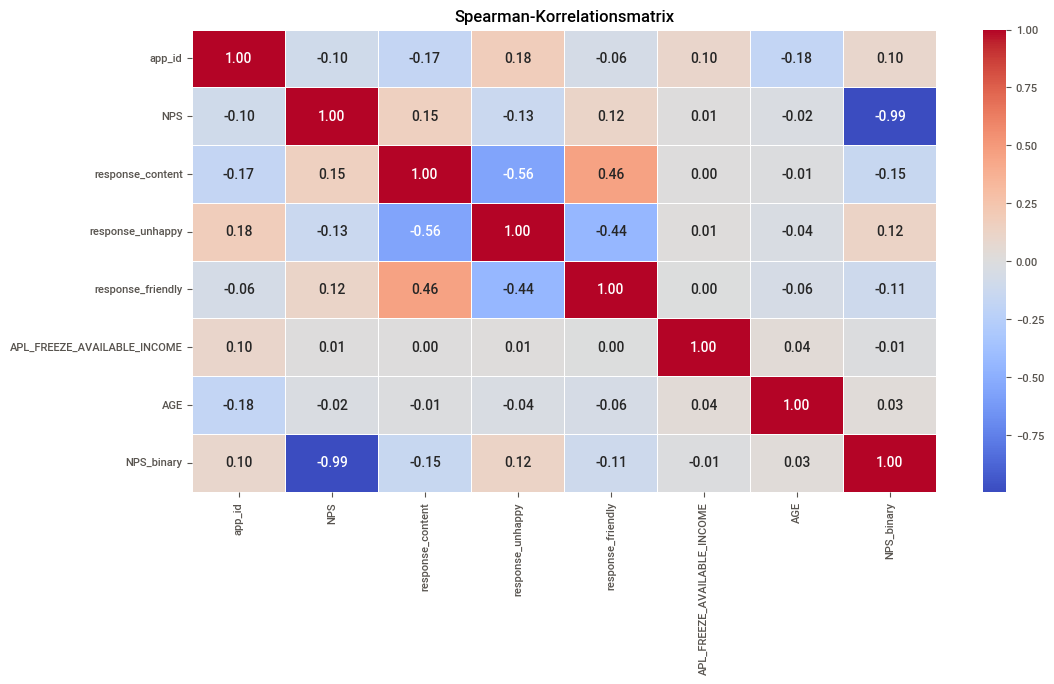

In [17]:
# Auswahl der numerischen Spalten
numeric_df = df.select_dtypes(include=["number"])

# Spearman-Korrelationsmatrix berechnen

spearman_corr_matrix = numeric_df.corr(method="spearman")

# Visualisierung der Spearman-Korrelation als Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(spearman_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Titel setzen
plt.title("Spearman-Korrelationsmatrix")
plt.show()

___
response_unhappy korreliert stark mit response_friendly. Bei response_friendly = 50 treten bspw. nur Samples auf, die ebenfalls bei response_unhappy = 50 haben.

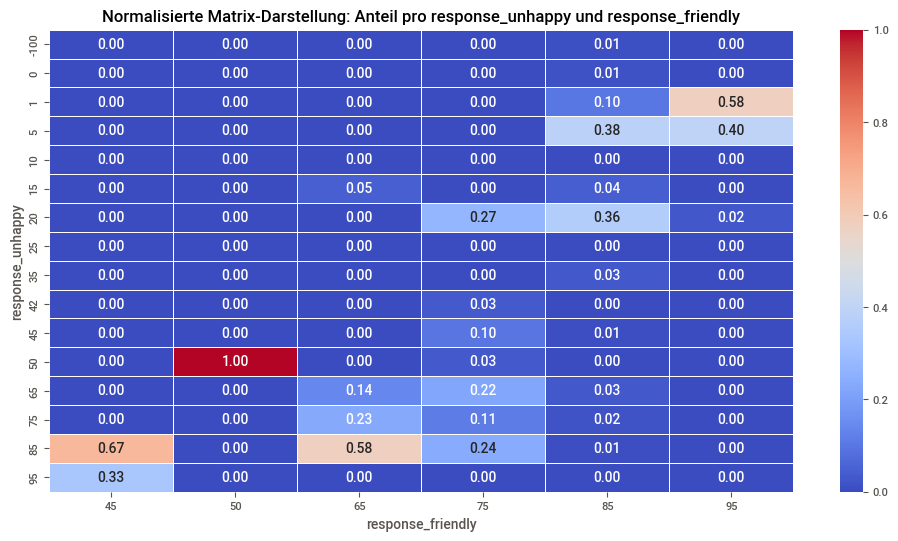

In [18]:
# Berechnung der Rohanzahlen pro response_unhappy und response_friendly
matrix_data = df.pivot_table(index="response_unhappy", columns="response_friendly", aggfunc="size", fill_value=0)

# Normalisierung innerhalb von response_unhappy (Spaltenweise Normierung)
matrix_data_normalized = matrix_data.div(matrix_data.sum(axis=0), axis=1)

# Erstellen der Heatmap mit normalisierten Werten
plt.figure(figsize=(12, 6))
sns.heatmap(matrix_data_normalized, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Titel und Achsenbeschriftungen setzen
plt.title("Normalisierte Matrix-Darstellung: Anteil pro response_unhappy und response_friendly")
plt.xlabel("response_friendly")
plt.ylabel("response_unhappy")

# Anzeige der Heatmap
plt.show()

___
Das gleiche gilt auch für response_unhappy und response_content. Auch hier lassen sich starke Korrelationen beobachten, sodass merhmals nur ein Wert in response_unhappy vorkommen kann, wenn response_content einen gewissen Wert annimmt.

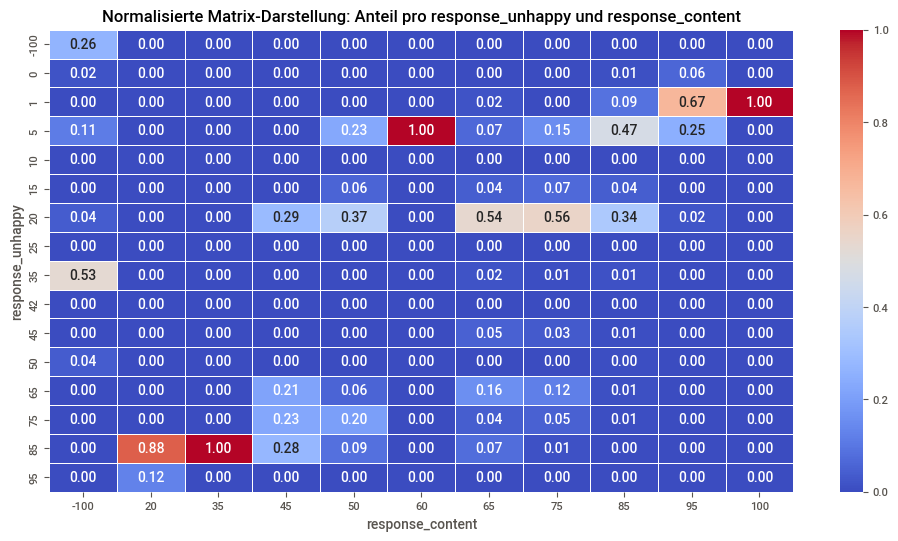

In [19]:
# Berechnung der Rohanzahlen pro response_unhappy und response_content
matrix_data = df.pivot_table(index="response_unhappy", columns="response_content", aggfunc="size", fill_value=0)

# Normalisierung innerhalb von response_unhappy (Spaltenweise Normierung)
matrix_data_normalized = matrix_data.div(matrix_data.sum(axis=0), axis=1)

# Erstellen der Heatmap mit normalisierten Werten
plt.figure(figsize=(12, 6))
sns.heatmap(matrix_data_normalized, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Titel und Achsenbeschriftungen setzen
plt.title("Normalisierte Matrix-Darstellung: Anteil pro response_unhappy und response_content")
plt.xlabel("response_content")
plt.ylabel("response_unhappy")

# Anzeige der Heatmap
plt.show()

___
Hier lässt sich erkennen, dass der Anteil der unzufriedenen Kunden zunimmt, je höher response_unhappy wird. Jedoch gibt es aufgrund der geringen Anzahl an unzufriedereneren Kunden (und insgesamt aufgrund der niedrigen Sample Size) hier auch große Konfidenzintervalle.

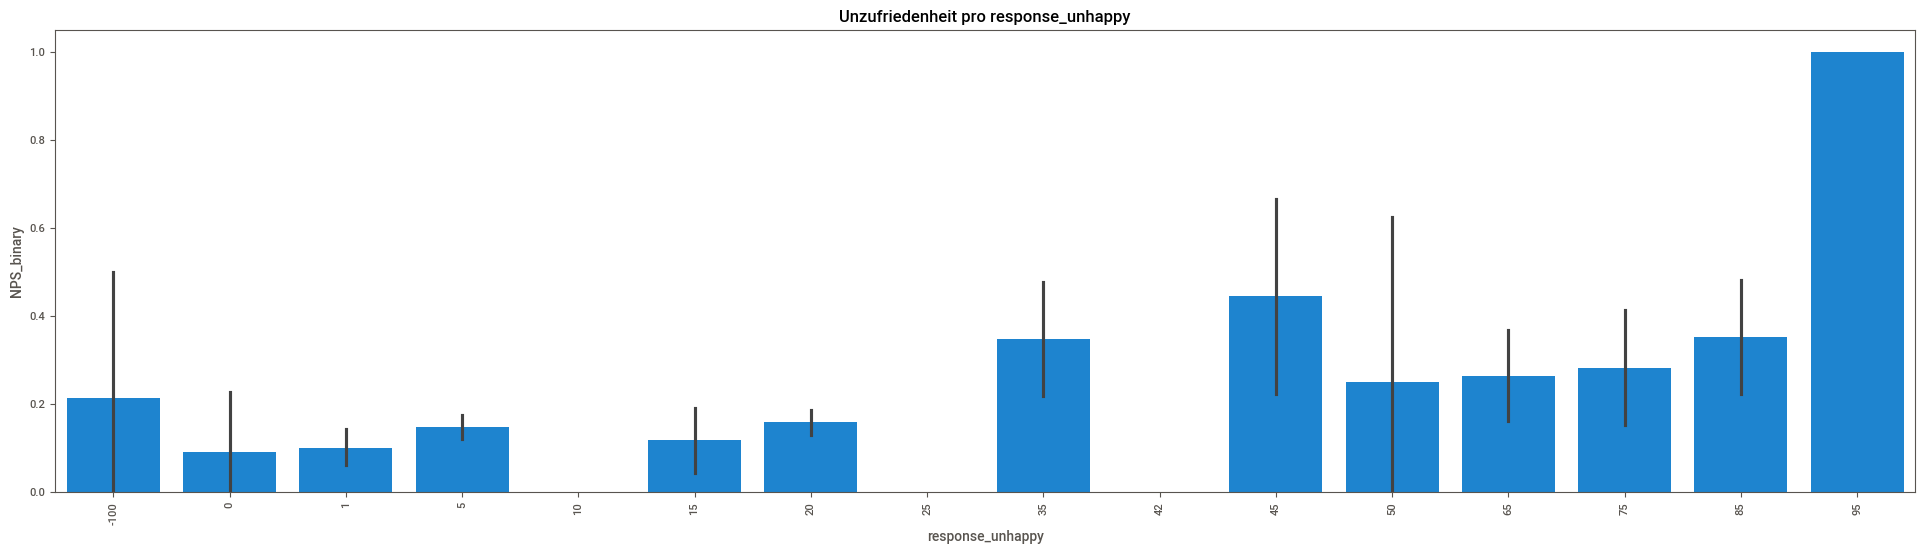

In [20]:
# Erstellen des Barplots zur Visualisierung der Unzufriedenheit pro response_unhappy
plt.figure(figsize=(24,6))
sns.barplot(data=df, x="response_unhappy", y='NPS_binary')

# Titel und Achsenbeschriftungen setzen
plt.xticks(rotation=90)

plt.xlabel("response_unhappy")
plt.ylabel("NPS_binary")
plt.title("Unzufriedenheit pro response_unhappy")

# Anzeige des Plots
plt.show()

___
Durch Logarithmierung wird die stark rechtsschiefe Verteilen des verfügbaren Einkommens stärker einer Normalverteilung angeglichen.

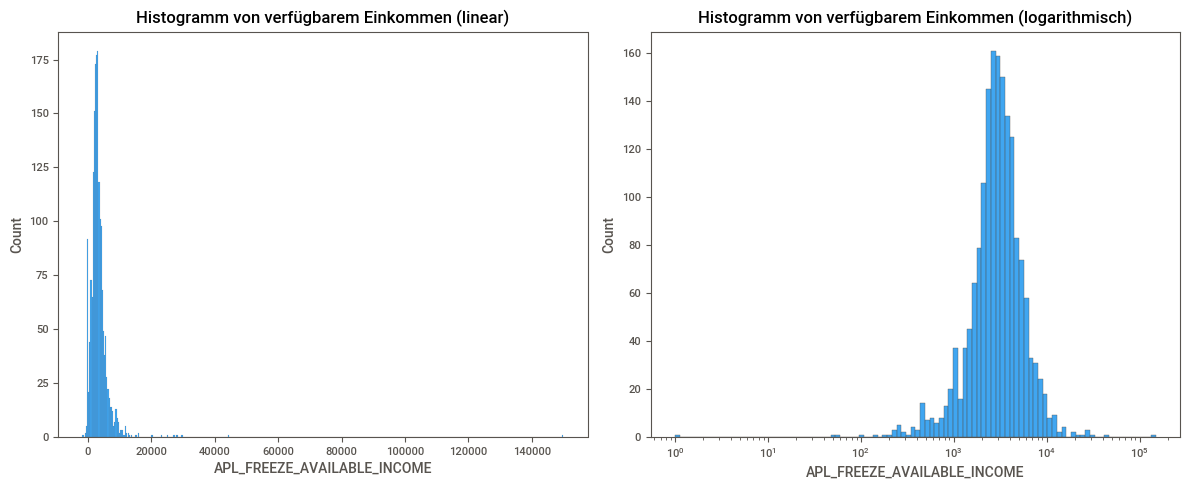

In [21]:
# Erstelle die Subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Lineares Histogramm (links)
sns.histplot(data=df, x='APL_FREEZE_AVAILABLE_INCOME', ax=axes[0])
axes[0].set_title("Histogramm von verfügbarem Einkommen (linear)")

# Logarithmisches Histogramm (rechts)
sns.histplot(data=df, x='APL_FREEZE_AVAILABLE_INCOME', log_scale=True, ax=axes[1])
axes[1].set_title("Histogramm von verfügbarem Einkommen (logarithmisch)")

# Layout-Anpassung
plt.tight_layout()
plt.show()

# Definition von Target und Features

In [22]:
X = df.drop(columns=["NPS", "NPS_binary"])  # Unabhängige Variablen
y = df["NPS_binary"]  # Zielvariable

In [23]:
X

,app_id,response_content,response_unhappy,response_friendly,APL_SEX,APL_FREEZE_AVAILABLE_INCOME,AGE
0,18683842,85,20,85,M,3408.36,56.0
1,21406925,85,1,85,M,2519.00,40.0
2,21406925,85,1,85,F,1400.00,37.0
3,100524024,75,20,85,M,3500.00,42.0
4,19866647,85,0,85,M,4264.67,38.0
...,...,...,...,...,...,...,...
1826,9866614,85,20,85,M,2873.00,70.0
1827,9866614,85,20,85,F,2600.00,75.0
1828,21383404,45,85,65,M,1462.89,63.0
1829,21383404,45,85,65,F,2755.00,64.0


In [24]:
y

,NPS_binary
0,1
1,0
2,0
3,0
4,0
...,...
1826,0
1827,0
1828,0
1829,0


# Train Test Split  

Aufzeigen, dass ein reiner stratifizierter Split gleiche app_ids in train und test erzeugen würde.

In [25]:
# Stratifizierten Split durchführen
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Überprüfung: Überschneidung von app_id zwischen Train und Test
overlap = set(X_train["app_id"]).intersection(set(X_test["app_id"]))
print(f"Überschneidende app_id-Werte zwischen Train und Test: {overlap}")

Überschneidende app_id-Werte zwischen Train und Test: {22111746, 100629507, 12557826, 17731589, 19702790, 21807111, 100792839, 7612936, 100201480, 17224715, 100289547, 17219079, 21772303, 17231375, 19089937, 101229586, 100818963, 18348052, 21314578, 100726806, 20490264, 21839897, 13987357, 21255710, 101079583, 101817888, 9952802, 100628516, 19688996, 100444710, 100337703, 20342315, 18976815, 18252336, 19310641, 21973551, 100653617, 19244079, 21256757, 9567280, 100693046, 19532855, 100201529, 5867064, 22239291, 21551164, 101104189, 14052921, 18295871, 100398144, 11325505, 22016578, 20001347, 100913220, 21160516, 21924422, 100964423, 20529736, 21215817, 21732424, 12352584, 21982788, 21810757, 12054092, 100164688, 100602963, 100539989, 21227606, 20213850, 12852827, 21318748, 21704283, 101702238, 14558815, 22216290, 22259299, 21846118, 16987238, 101071469, 101384814, 18490996, 21220982, 100168312, 17416824, 101177467, 100676732, 100328066, 19824771, 21061767, 101373064, 101701255, 21830284

Verwenden der stratified_group_split Funktion, sodass die gleiche app_id nur in train oder test landen kann.

In [26]:
# Stratifizierten Split mit Gruppierung nach app_id durchführen
X_train, X_test, y_train, y_test = stratified_group_split(X, y, groups=X["app_id"], test_size=0.3, random_state=42)

# Überprüfung: Überschneidung von app_id zwischen Train und Test
overlap = set(X_train["app_id"]).intersection(set(X_test["app_id"]))
print(f"Überschneidende app_id-Werte zwischen Train und Test: {overlap}")

Überschneidende app_id-Werte zwischen Train und Test: set()


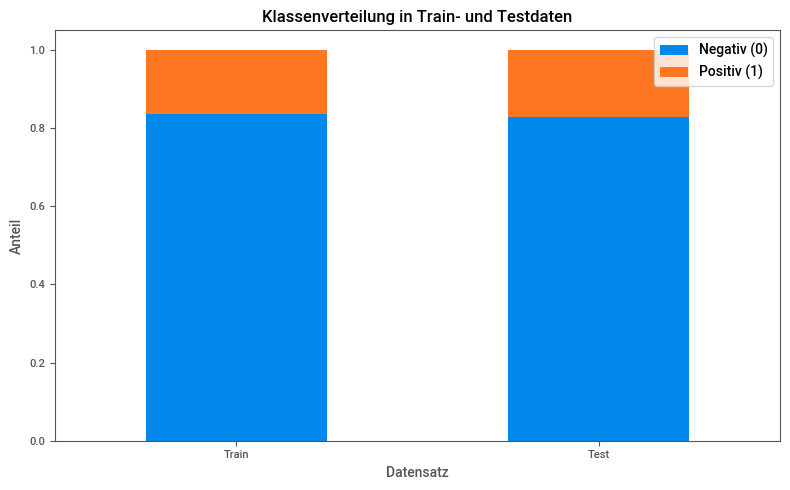

In [27]:
# Anteil positiver/negativer Klassen in Train/Test berechnen
train_dist = y_train.value_counts(normalize=True).rename("Train")
test_dist = y_test.value_counts(normalize=True).rename("Test")

# Zusammenführen zu DataFrame
class_dist_df = pd.concat([train_dist, test_dist], axis=1).T
class_dist_df.columns = ["Negativ (0)", "Positiv (1)"]

# Plot erstellen
ax = class_dist_df.plot(kind="bar", stacked=True, figsize=(8, 5))
plt.title("Klassenverteilung in Train- und Testdaten")
plt.ylabel("Anteil")
plt.xlabel("Datensatz")
plt.xticks(rotation=0)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

In [28]:
# Liste der grundlegend zu entfernenden Features - hier könnte man sich überlegen app_id zu entfernen, wenn dies fachlich erforderlich ist - dies wäre abzuklären
features_to_drop = [] #['app_id']

X_train_for_models = X_train.drop(columns=features_to_drop)
X_test_for_models = X_test.drop(columns=features_to_drop)

# Baseline Model: Logistische Regression

Die logistische Regression dient als Baseline Model da:
- geeignet für lineare Zusammenhänge
- gut zu interpretieren
- als Vergleichswert für komplexere Modelle nutzbar

## Datenvorverarbeitung für Logistische Regression

Die Daten werden folgendermaßen vorbereitet:

- One-Hot-Encoding der kategorialen Features und entfernen der Basisausprägung, um Multikollinearität zu vermeiden
- Skalieren der numerischen Features um diese auf eine vergleichbare Skala zu bringen

In [29]:
# Liste der zu entfernenden Features für Logistische Regression - es wird kein Feature entfernt, da die vorliegenden Korrelationen vermutlich nicht zu stark sind
features_to_drop = []

# Mögliches Entfernen der Features aus X_train und X_test
X_train_lr = X_train_for_models.copy().drop(columns=features_to_drop)
X_test_lr = X_test_for_models.copy().drop(columns=features_to_drop)

In [30]:
# Identifiziere kategorische und numerische Features
categorical_features = X_train_lr.select_dtypes(include=['object']).columns.tolist()
numerical_features = X_train_lr.select_dtypes(include=['number']).columns.tolist()

# Iteriere durch die Features in X_train_lr
for feature in X_train_lr.columns:
    # Wenn das Feature numerisch ist, fülle fehlende Werte mit dem Modus
    if feature in numerical_features:
        mode_value = X_train_lr[feature].mode()[0]
        X_train_lr[feature] = X_train_lr[feature].fillna(mode_value)
        X_test_lr[feature] = X_test_lr[feature].fillna(mode_value)
    # Wenn das Feature kategorisch ist, fülle fehlende Werte mit dem Modus
    elif feature in categorical_features:
        mode_value = X_train_lr[feature].mode()[0]
        X_train_lr[feature] = X_train_lr[feature].fillna(mode_value)
        X_test_lr[feature] = X_test_lr[feature].fillna(mode_value)

One-Hot-Encoding der kategorialen Features.

In [31]:
# OHE inklusive drop_first=True für Logistische Regression
X_train_lr_encoded = pd.get_dummies(X_train_lr, columns=["APL_SEX"], drop_first=True).astype(int)
X_test_lr_encoded = pd.get_dummies(X_test_lr, columns=["APL_SEX"], drop_first=True).astype(int)

Skalieren der numerischen Features um diese auf eine vergleichbare Skala zu bringen. Fit auf train, anwenden auf test.

In [32]:
# Initialisiere den StandardScaler
scaler = StandardScaler()

# Fitte den Scaler nur auf X_train und wende ihn auf X_test an, sodass Data Leakage verhindert wird
X_train_lr_encoded[numerical_features] = scaler.fit_transform(X_train_lr_encoded[numerical_features])
X_test_lr_encoded[numerical_features] = scaler.transform(X_test_lr_encoded[numerical_features])

In [33]:
X_train_lr_encoded

,app_id,response_content,response_unhappy,response_friendly,APL_FREEZE_AVAILABLE_INCOME,AGE,APL_SEX_M
0,-0.723589,0.302420,0.148102,0.116687,-0.004174,0.760493,1
1,-0.655236,0.302420,-0.660665,0.116687,-0.177999,-0.613823,1
2,-0.655236,0.302420,-0.660665,0.116687,-0.396796,-0.871507,0
3,1.330701,-0.001357,0.148102,0.116687,0.013815,-0.442033,1
5,1.350473,0.302420,2.489269,-1.878332,0.199176,-0.442033,0
...,...,...,...,...,...,...,...
1823,-0.640265,0.302420,-0.064732,0.116687,-0.142804,0.588703,1
1826,-0.944912,0.302420,0.148102,0.116687,-0.108782,1.963018,1
1827,-0.944912,0.302420,0.148102,0.116687,-0.162161,2.392492,0
1828,-0.655827,-0.912690,2.914935,-3.873350,-0.384673,1.361755,1


Betrachtung der erzeugten Z-Werte, um später die gebildeten Koeffizienten und Odds-Ratios besser interpretieren zu könne, da je größer die Z-Spanne eines Features ist, desto mehr Einfluss kann es über den Koeffizienten hinweg akkumulieren – vorausgesetzt, der Wert ändert sich auch entsprechend im Datensatz.

In [34]:
X_train_lr_encoded.describe()

,app_id,response_content,response_unhappy,response_friendly,APL_FREEZE_AVAILABLE_INCOME,AGE,APL_SEX_M
count,1.231000e+03,1.231000e+03,1.231000e+03,1.231000e+03,1.231000e+03,1.231000e+03,1231.000000
mean,2.308831e-17,-9.235324e-17,1.154415e-17,-9.523928e-16,-2.886039e-17,-2.020227e-16,0.531275
std,1.000406e+00,1.000406e+00,1.000406e+00,1.000406e+00,1.000406e+00,1.000406e+00,0.499224
min,-1.150229e+00,-5.317463e+00,-4.959899e+00,-7.863387e+00,-8.097529e-01,-1.988138e+00,0.000000
25%,-7.215155e-01,-1.357251e-03,-4.903985e-01,1.166867e-01,-2.994225e-01,-7.856120e-01,0.000000
50%,-6.543506e-01,3.024202e-01,-6.473177e-02,1.166867e-01,-1.191449e-01,-2.702438e-01,1.000000
75%,1.328754e+00,3.024202e-01,1.481016e-01,1.166867e-01,1.269282e-01,6.745978e-01,1.000000
max,1.368012e+00,7.580865e-01,3.340602e+00,2.111705e+00,2.865880e+01,4.282175e+00,1.000000


In [35]:
X_test_lr_encoded

,app_id,response_content,response_unhappy,response_friendly,APL_FREEZE_AVAILABLE_INCOME,AGE,APL_SEX_M
4,-0.693899,0.30242,-0.703232,0.116687,0.163199,-0.785612,1
6,1.326769,0.30242,-0.703232,0.116687,-0.670536,0.073335,0
7,1.326769,0.30242,-0.703232,0.116687,0.082250,0.245124,1
12,-0.665945,0.30242,-0.490398,0.116687,0.242192,-0.184349,0
17,-0.683203,0.30242,-0.490398,0.116687,0.547609,0.674598,1
...,...,...,...,...,...,...,...
1817,-0.654834,-0.91269,2.914935,-3.873350,-0.097832,-0.613823,1
1821,1.347077,0.30242,-0.490398,0.116687,-0.168418,2.736070,0
1824,-1.054820,0.30242,1.425102,0.116687,-0.338137,1.275861,1
1825,-1.054820,0.30242,1.425102,0.116687,-0.592325,0.674598,0


In [36]:
X_test_lr_encoded.describe()

,app_id,response_content,response_unhappy,response_friendly,APL_FREEZE_AVAILABLE_INCOME,AGE,APL_SEX_M
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,0.004656,0.024970,0.048992,0.021923,-0.037722,0.016501,0.526667
std,1.000841,0.985407,0.929015,0.950249,0.482520,0.963516,0.499705
min,-1.102243,-5.317463,-4.959899,-7.863387,-1.011148,-1.902243,0.000000
25%,-0.720098,0.302420,-0.490398,0.116687,-0.313305,-0.785612,0.000000
50%,-0.654267,0.302420,-0.064732,0.116687,-0.110933,-0.184349,1.000000
75%,1.328710,0.302420,0.148102,0.116687,0.132696,0.588703,1.000000
max,1.367533,0.758086,2.914935,2.111705,4.869384,3.165544,1.000000


## Modelltraining

In [37]:
# Initialisiere das Modell
lr_model = LogisticRegression(max_iter=1000, random_state=42)

# Trainiere das Modell
lr_model.fit(X_train_lr_encoded, y_train)

LogisticRegression(max_iter=1000, random_state=42)

## Vorhersage und Evaluierung der Ergebnisse

Bestimme den Threshold, um bewerten zu können, wie gut die Performance des Modells ist, wenn man die obersten 20% der Vorhersage betrachten würde.

In [38]:
# 80. Perzentil der vorhergesagten Wahrscheinlichkeiten der Logistischen Regression auf dem train Datensatz
top_20_lr = np.percentile(lr_model.predict_proba(X_train_lr_encoded)[:,1], 100 - 20)
print(top_20_lr)

0.1886228295330469


In [39]:
# Threshold für die Evaluation so festlegen, dass die obersten 20% der vorhergesagten Wahrscheinlichkeit (bestimmt auf train) geprüft werden würden
THRESHOLD = top_20_lr

# Modell evaluieren
results_lr = evaluate_model(lr_model, X_train_lr_encoded, y_train, X_test_lr_encoded, y_test, threshold=THRESHOLD)

Modellmetriken Train vs. Test für den Threshold 0.1886228295330469:
       Accuracy  Precision  Recall  F1-Score
Train    0.7417     0.2672  0.3251    0.2933
Test     0.7267     0.2520  0.3010    0.2743


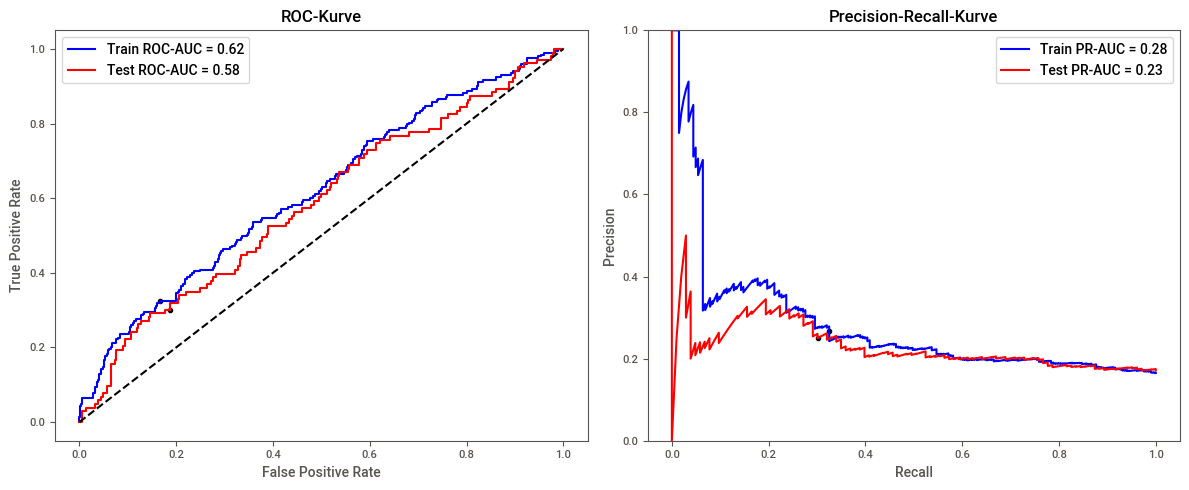

In [40]:
# ROC und PR Kurven zeichnen, Threshold ist auf der Kurve markiert
plot_roc_pr_curves(results_lr, threshold=THRESHOLD)

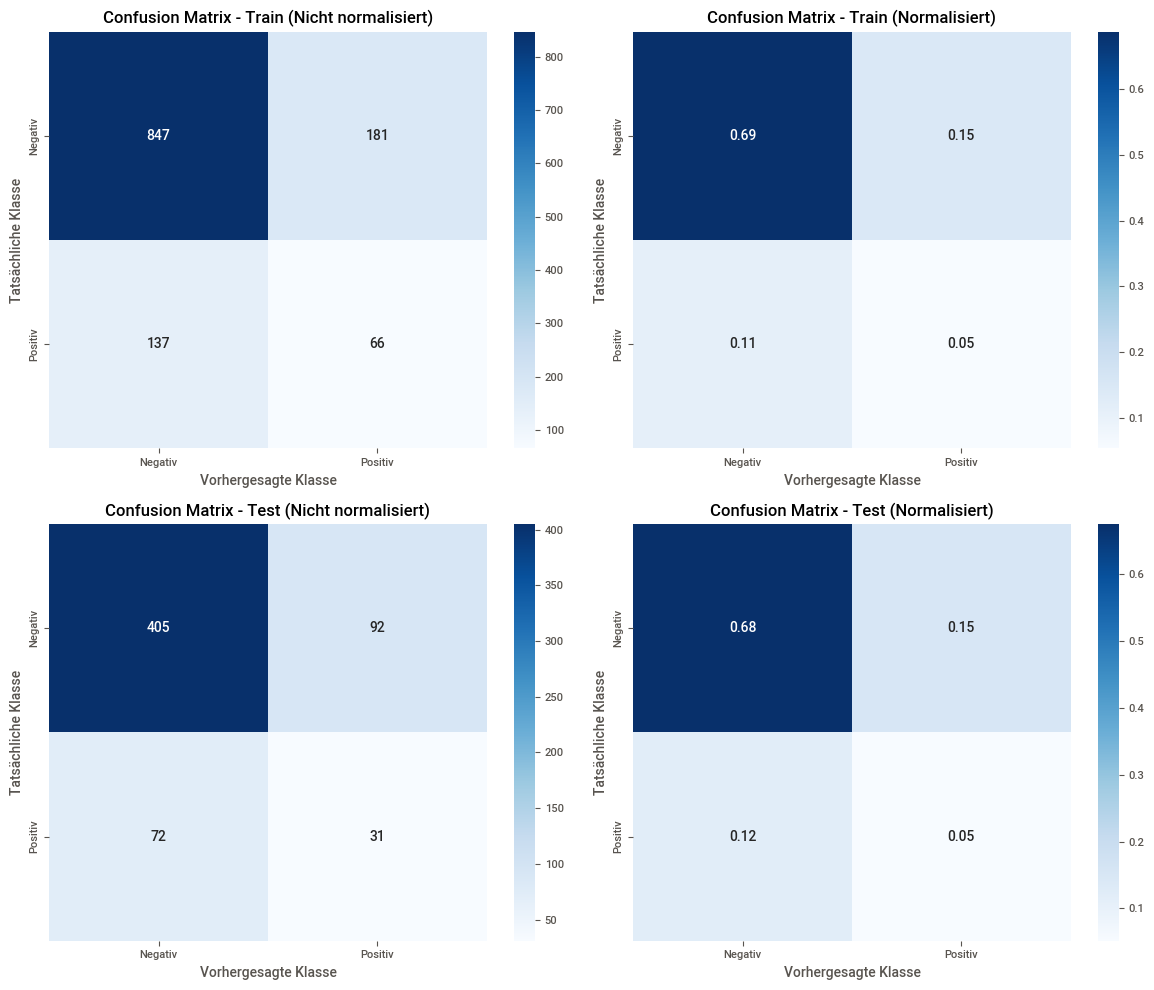

In [41]:
# Confusion Matrizes für den gewählten Threshold
plot_confusion_matrices(results_lr)

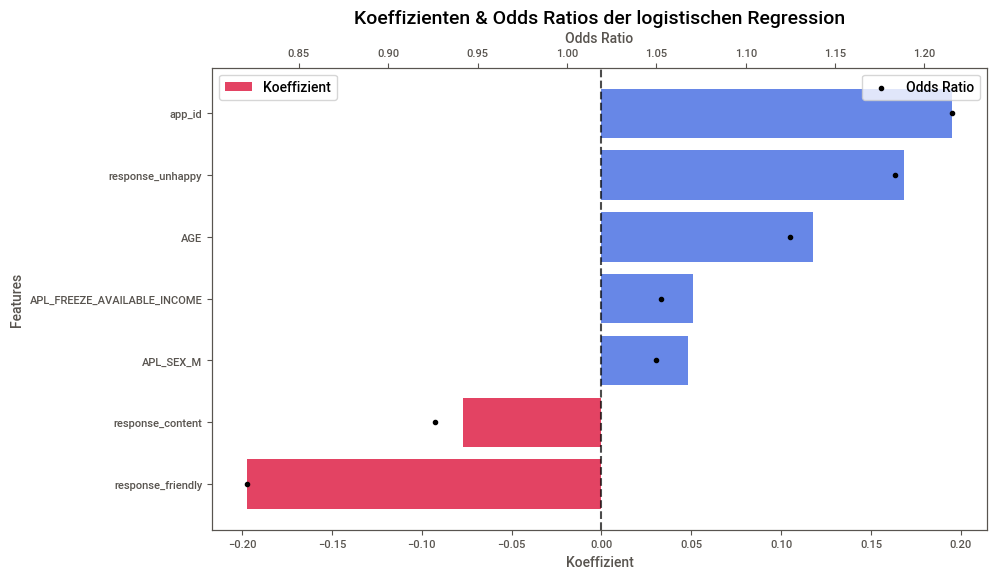

In [42]:
# Koeffizienten abrufen
coefficients = lr_model.coef_[0]  # Da es ein binäres Modell ist, nehmen wir die erste Spalte

features = X_train_lr_encoded.columns

# Erstelle DataFrame mit Koeffizienten und Odds Ratios
coef_df = pd.DataFrame({'Feature': features, 'Koeffizient': coefficients})
coef_df['Odds Ratio'] = np.exp(coef_df['Koeffizient'])

# Sortieren für bessere Darstellung
coef_df = coef_df.sort_values(by='Koeffizient', ascending=True)

# Balkendiagramm mit Seaborn (Koeffizienten & Odds Ratios)
fig, ax1 = plt.subplots(figsize=(10, 6))

# Farben für positive und negative Werte
colors = ['royalblue' if coef > 0 else 'crimson' for coef in coef_df['Koeffizient']]

# Balkendiagramm für Koeffizienten
ax1.barh(coef_df['Feature'], coef_df['Koeffizient'], color=colors, alpha=0.8, label="Koeffizient")
ax1.set_xlabel("Koeffizient")
ax1.set_ylabel("Features")
ax1.axvline(x=0, color='black', linestyle='--', alpha=0.7)  # Null-Linie

# Zweite Achse für Odds Ratios
ax2 = ax1.twiny()
ax2.scatter(coef_df['Odds Ratio'], coef_df['Feature'], color='black', marker='o', label="Odds Ratio")
ax2.set_xlabel("Odds Ratio")
ax2.set_xscale("linear")  # Keine log-Skalierung

# Titel setzen und Legende hinzufügen
plt.title("Koeffizienten & Odds Ratios der logistischen Regression", fontsize=14)
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()

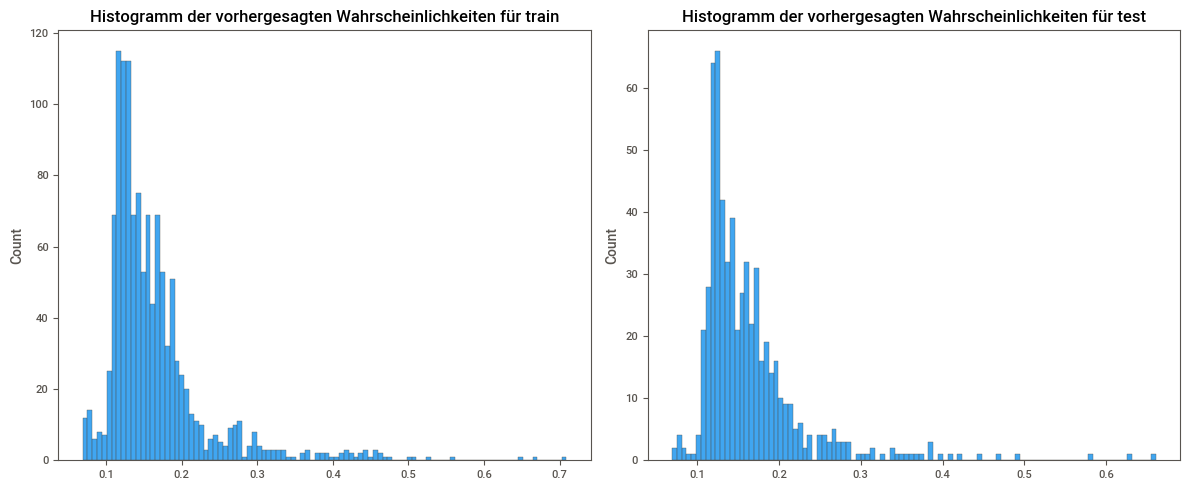

In [43]:
# Erstelle die Subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 Zeile, 2 Spalten

# Lineares Histogramm (links)
sns.histplot(data=lr_model.predict_proba(X_train_lr_encoded)[:,1], bins=100, ax=axes[0])
axes[0].set_title("Histogramm der vorhergesagten Wahrscheinlichkeiten für train")

# Logarithmisches Histogramm (rechts)
sns.histplot(data=lr_model.predict_proba(X_test_lr_encoded)[:,1], bins=100, ax=axes[1])
axes[1].set_title("Histogramm der vorhergesagten Wahrscheinlichkeiten für test")

# Layout-Anpassung
plt.tight_layout()
plt.show()

In [44]:
# Anzahl der unterschiedlichen ausgegebenen Wahrscheinlichkeiten für die Logistische Regression auf dem train set - Erklärung für die zackigen Kurven bei ROC und PR bei der Logistischen Regression
pd.Series(lr_model.predict_proba(X_train_lr_encoded)[:, 1]).nunique()

1229

# LightGBM

- Einsatz von Gradient Boosting Machines State of the Art bei Problemen wie dem vorliegenden.
- In der Lage auch nicht-lineare Zusammenhänge abzubilden, weshalb es die Logistische Regression outperformen sollte, wenn nicht-lineare Zusammenhänge in den Daten vorhanden sind.
- Kaum Vorverarbeitung notwendig, da LightGBM auch mit kategorialen Features umgehen kann, ohne ein OHE durchzuführen.
- Achtung: GBMs neigen durch das sequenzielle Training der Bäume stark zum Overfitting, weshalb bestenfalls geeignete Parameter zur Regularisierung gefunden werden.

## Datenvorbereitung für LightGBM

- Umwandlung kategorialer Features in Datentyp Category.
- Wäre dadurch, dass hier nur 1 kategoriales Feature mit 2 Ausprägungen ist, so nicht nötig gewesen. Jedoch sollte das Analysenotebook aus meiner Sicht direkt so angelegt werden, dass bei späterem Hinzukommen weiterer kategorialer Features (mit mehr als 2 Ausprägungen) das Notebook nicht zusätzlich angepasst werden muss.


In [45]:
# Liste der kategorischen Features
categorical_features = ["APL_SEX"]

# X_train und X_test für LightGBM Vorverarbeitung kopieren
X_train_lgbm = X_train_for_models.copy()
X_test_lgbm = X_test_for_models.copy()

# Umwandlung in den Datentyp 'category'
for col in categorical_features:
    X_train_lgbm[col] = X_train_lgbm[col].astype('category')
    X_test_lgbm[col] = X_test_lgbm[col].astype('category')


Fixierung der kategorischen Indizes beim LGBMClassifier.

In [46]:
# Indizes der kategorischen Spalten ermitteln
categorical_indices = [X_train_lgbm.columns.get_loc(col) for col in categorical_features]

# Standardmodell
LGBMClassifier = lgbm.LGBMClassifier

# fit()-Methode patchen, sodass 'categorical_feature' immer automatisch gesetzt wird
LGBMClassifier.fit = partialmethod(
    LGBMClassifier.fit,
    categorical_feature=categorical_indices
)

## Hyperparameter Tuning via GridSearch

Auch bei der GridSearchCV muss wieder darauf geachtet werden, dass gleiche app_ids nur in einem der Folds vorkommen, um Target Leakage bei der Cross-Validation zu vermeiden.

In [47]:
# Parametergrid für die Gridsearch
param_grid = {
    'n_estimators': [50, 100],
    # Anzahl der Bäume im Boosting-Prozess
    # Mehr Bäume = mehr Modellkomplexität, kann Overfitting begünstigen
    # Bei kleiner learning_rate dürfen es mehr Trees sein (z. B. 300+)

    'learning_rate': [0.05, 0.1],
    # Lernrate = Schrittweite, mit der neue Bäume zur Vorhersage beitragen
    # Kleinere Werte führen zu robusterem Modell (weniger Overfitting),
    # benötigen dafür aber mehr Bäume (n_estimators)

    'max_depth': [2, 3, 5],
    # Maximale Tiefe eines einzelnen Baums
    # Höhere Tiefe = komplexere Regeln = Gefahr von Overfitting
    # Niedrigere Tiefe zwingt das Modell zu einfacheren (verallgemeinerten) Regeln

    'min_child_samples': [5, 10, 20],
    # Mindestanzahl an Samples, die ein Blatt enthalten muss
    # Höherer Wert = weniger komplexe Bäume = reguliert Overfitting

    'min_split_gain': [1, 5, 10],
    # Mindestgewinn (Gain), den ein Split bringen muss, damit er durchgeführt wird
    # Erhöht man diesen Wert, werden nur Splits gemacht, die einen echten Mehrwert bringen
    # → Modell wird konservativer, verhindert unnötiges Overfitting
}

# CV-Generator
cv_generator = stratified_group_cv(X_train_lgbm, y_train, groups=X_train["app_id"])

# GridSearchCV mit benutzerdefinierter CV-Logik
grid_search = GridSearchCV(
    estimator=LGBMClassifier(random_state=42),
    param_grid=param_grid,
    scoring='average_precision', #PR-AUC-Score
    cv=cv_generator,
    n_jobs=-1
)

# GridSearch starten
grid_search.fit(X_train_lgbm, y_train)

[LightGBM] [Info] Number of positive: 203, number of negative: 1028
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 600
[LightGBM] [Info] Number of data points in the train set: 1231, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.164907 -> initscore=-1.622164
[LightGBM] [Info] Start training from score -1.622164
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

GridSearchCV(cv=<generator object _BaseKFold.split at 0x7e7ecc14e0e0>,
             estimator=LGBMClassifier(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [2, 3, 5],
                         'min_child_samples': [5, 10, 20],
                         'min_split_gain': [1, 5, 10],
                         'n_estimators': [50, 100]},
             scoring='average_precision')

In [48]:
# Beste Parameter und Score anzeigen
print(f'Beste Parameter: {grid_search.best_params_}, Bester Score: {grid_search.best_score_}')

Beste Parameter: {'learning_rate': 0.1, 'max_depth': 2, 'min_child_samples': 5, 'min_split_gain': 5, 'n_estimators': 50}, Bester Score: 0.2572475435065488


## Modelltraining

In [49]:
# LightGBM trainieren
lgbm_model = LGBMClassifier(**grid_search.best_params_, importance_type="gain", random_state=42)
lgbm_model.fit(X_train_lgbm, y_train)

[LightGBM] [Info] Number of positive: 203, number of negative: 1028
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000071 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 600
[LightGBM] [Info] Number of data points in the train set: 1231, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.164907 -> initscore=-1.622164
[LightGBM] [Info] Start training from score -1.622164
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

LGBMClassifier(importance_type='gain', max_depth=2, min_child_samples=5,
               min_split_gain=5, n_estimators=50, random_state=42)

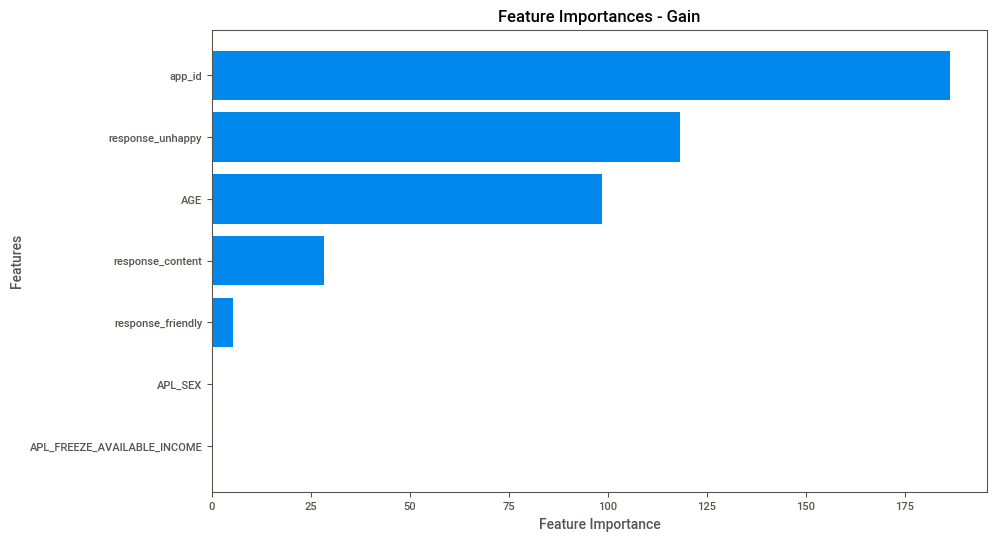

In [50]:
# Feature Importances ausgeben
feature_importance = pd.DataFrame({'Feature': X_train_lgbm.columns, 'Importance': lgbm_model.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Plot erstellen
plt.figure(figsize=(10, 6))
plt.barh(feature_importance["Feature"], feature_importance["Importance"], align="center")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importances - Gain")
plt.gca().invert_yaxis()  # Wichtig, damit das wichtigste Feature oben steht
plt.show()

Bestimme auch hier den Threshold, um bewerten zu können, wie gut die Performance des Modells ist, wenn man die obersten 20% der Vorhersage betrachten würde.

In [51]:
# 80. Perzentil der vorhergesagten Wahrscheinlichkeiten des LightGBM auf dem train Datensatz
top_20_lgbm = np.percentile(lgbm_model.predict_proba(X_train_lgbm)[:,1], 100 - 20)
print(top_20_lgbm)

0.17803016987853904


Es zeigt sich noch ein Overfitting des Modells, jedoch im Test-Set dennoch bessere Performance als bei der Logistischen Regression. Hier müsste dennoch weiter an den Parametern optimiert werden.

In [52]:
# Threshold für die Evaluation so festlegen, dass die obersten 20% der vorhergesagten Wahrscheinlichkeit (bestimmt auf train) geprüft werden würden
THRESHOLD = top_20_lgbm

# Modell evaluieren
results_lgbm = evaluate_model(lgbm_model, X_train_lgbm, y_train, X_test_lgbm, y_test, threshold=THRESHOLD)

Modellmetriken Train vs. Test für den Threshold 0.17803016987853904:
       Accuracy  Precision  Recall  F1-Score
Train    0.7587     0.3192  0.4089    0.3585
Test     0.7350     0.2941  0.3883    0.3347


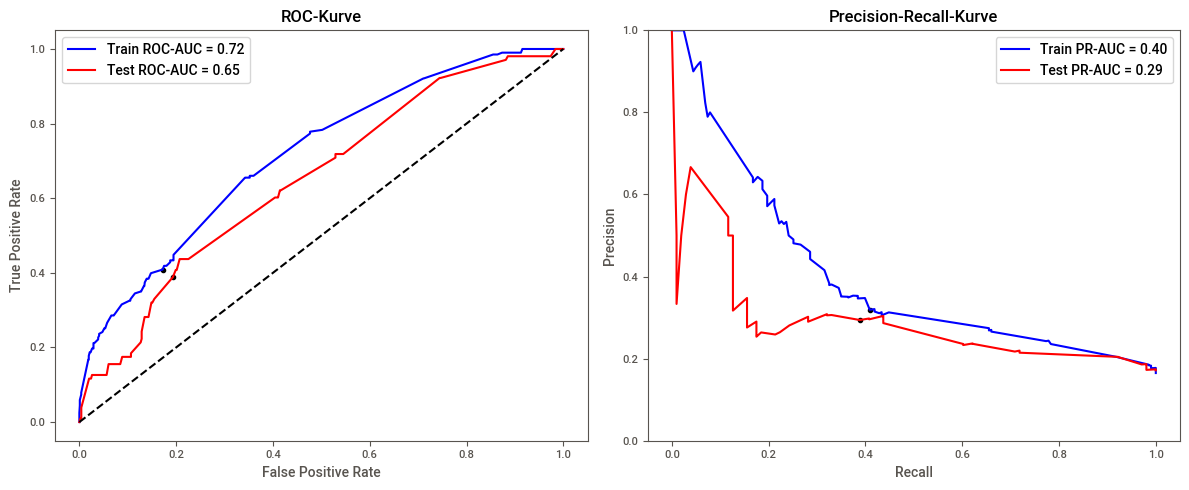

In [53]:
# ROC und PR Kurven zeichnen, Threshold ist auf der Kurve markiert
plot_roc_pr_curves(results_lgbm, threshold=THRESHOLD)

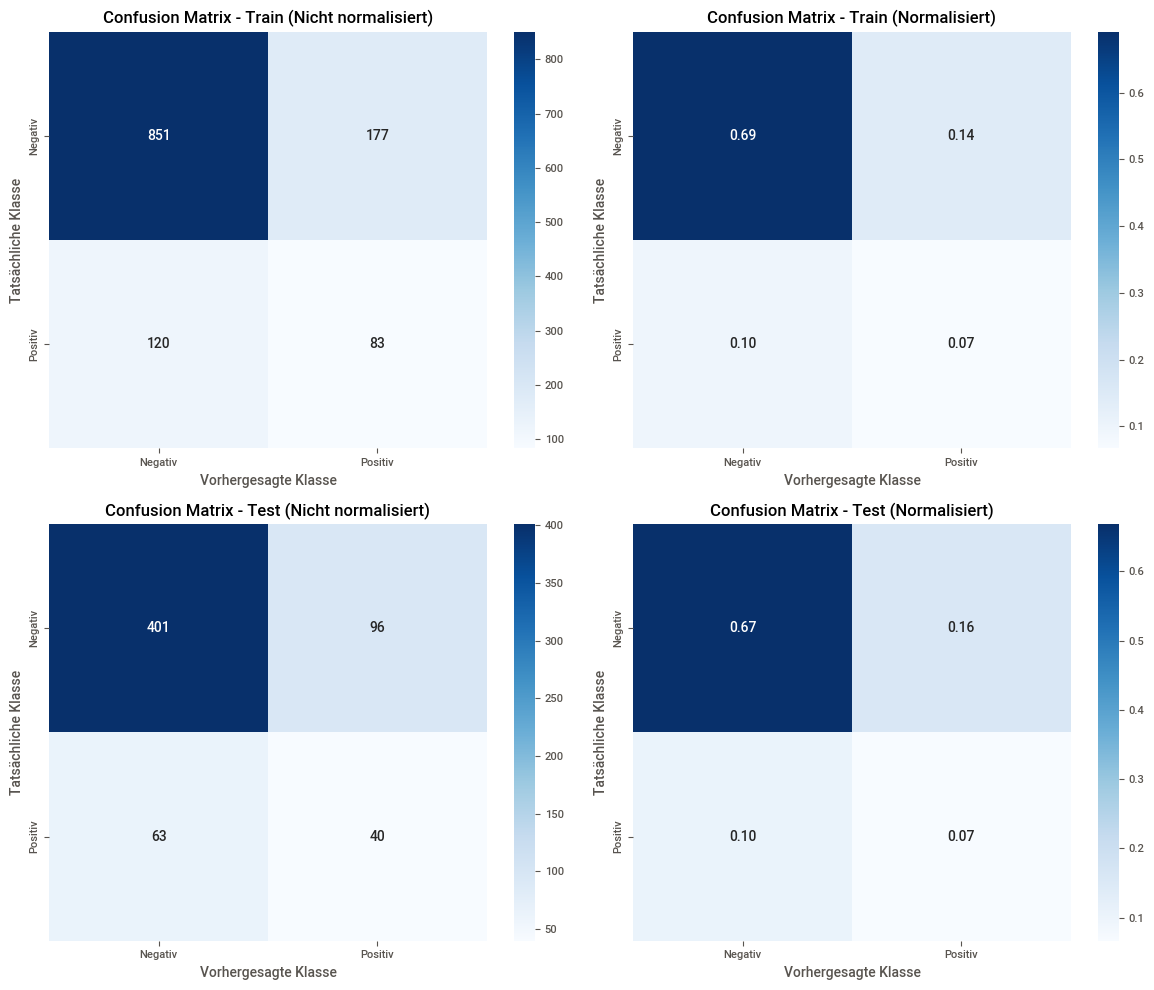

In [54]:
# Confusion Matrizes für den gewählten Threshold
plot_confusion_matrices(results_lgbm)

Berechnung von Shap Values und Erstellen diverser Plots, um bessere Einblicke in die Wirkung diverser Feature-Ausprägungen zu erhalten. Sie zeigen, wie stark jedes einzelne Feature die Vorhersage eines Modells beeinflusst – also ob es sie höher oder niedriger macht. Der TreeExplainer berechnet das, indem er alle möglichen Entscheidungswege im Baum betrachtet und prüft, welchen Beitrag ein Feature auf diesen Wegen zur Vorhersage leistet.

/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


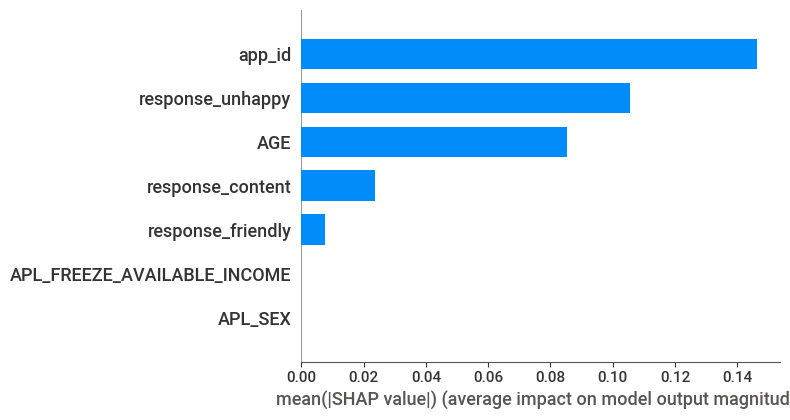

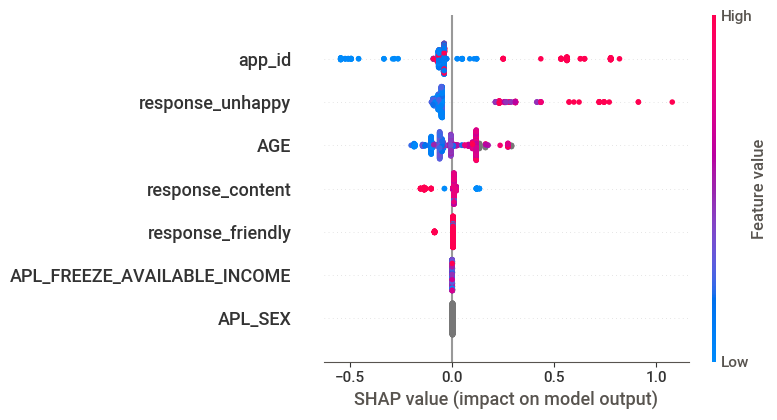

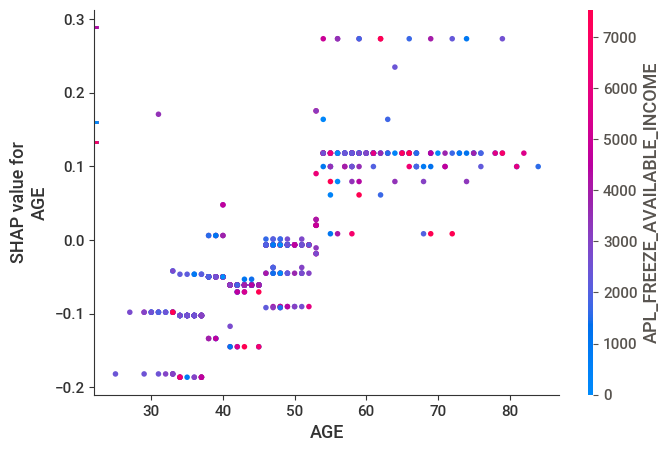

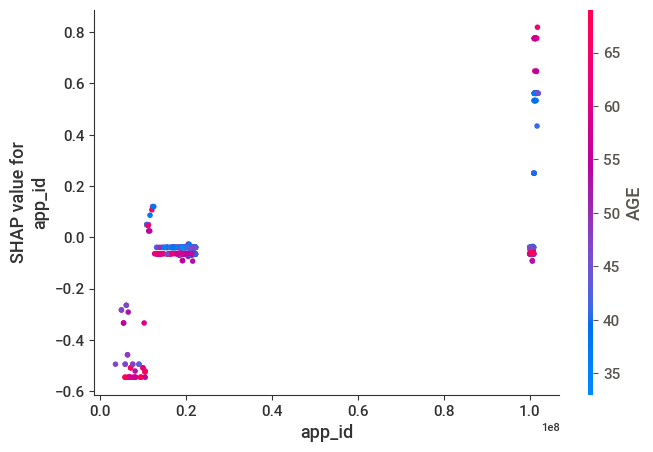

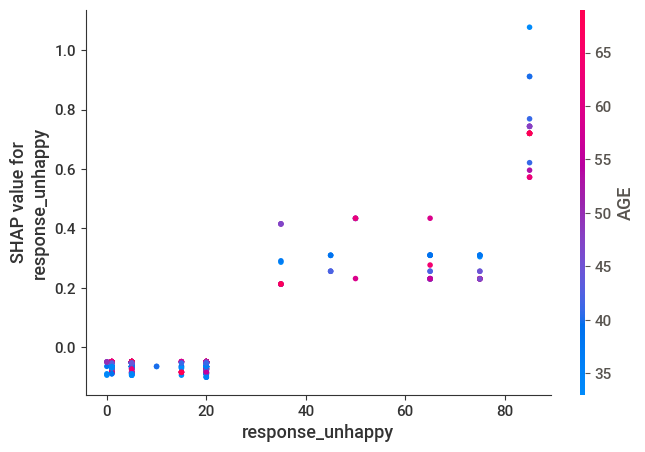

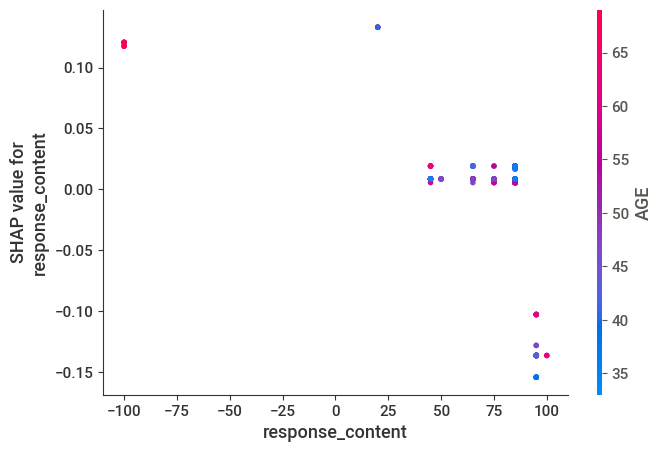

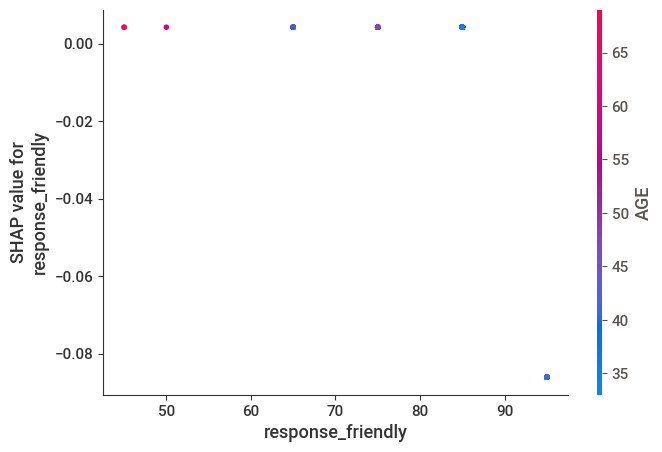

<Figure size 640x480 with 0 Axes>

In [55]:
# SHAP-Explainer für LightGBM mit TreeExplainer
explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer.shap_values(X_test_lgbm)

# SHAP-Barplot für Feature Importance
shap.summary_plot(shap_values, X_test_lgbm, plot_type="bar")

# SHAP-Beeswarm-Plot für detaillierte Feature-Analyse
shap.summary_plot(shap_values, X_test_lgbm)

# SHAP-Dependence Plot für AGE mit farblicher Kodierung nach APL_FREEZE_AVAILABLE_INCOME
shap.dependence_plot("AGE", shap_values, X_test_lgbm, interaction_index="APL_FREEZE_AVAILABLE_INCOME")

# SHAP-Dependence Plot für response_unhappy mit farblicher Kodierung nach AGE
shap.dependence_plot("app_id", shap_values, X_test_lgbm, interaction_index="AGE")

# SHAP-Dependence Plot für response_unhappy mit farblicher Kodierung nach AGE
shap.dependence_plot("response_unhappy", shap_values, X_test_lgbm, interaction_index="AGE")

# SHAP-Dependence Plot für response_content mit farblicher Kodierung nach AGE
shap.dependence_plot("response_content", shap_values, X_test_lgbm, interaction_index="AGE")

# SHAP-Dependence Plot für response_unhappy mit farblicher Kodierung nach AGE
shap.dependence_plot("response_friendly", shap_values, X_test_lgbm, interaction_index="AGE")

plt.tight_layout()
plt.show()


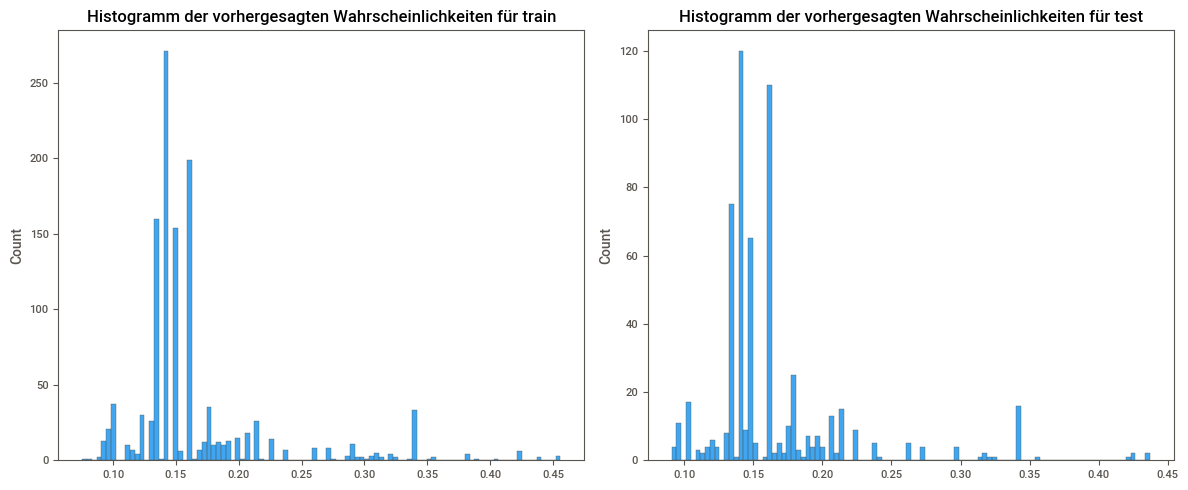

In [56]:
# Erstelle die Subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Lineares Histogramm (links)
sns.histplot(data=lgbm_model.predict_proba(X_train_lgbm)[:,1], bins=100, ax=axes[0])
axes[0].set_title("Histogramm der vorhergesagten Wahrscheinlichkeiten für train")

# Logarithmisches Histogramm (rechts)
sns.histplot(data=lgbm_model.predict_proba(X_test_lgbm)[:,1], bins=100, ax=axes[1])
axes[1].set_title("Histogramm der vorhergesagten Wahrscheinlichkeiten für test")

# Layout-Anpassung
plt.tight_layout()
plt.show()

In [57]:
# Niedrige Anzahl an unterschiedlichen ausgegebenen Wahrscheinlichkeiten für das LightGBM auf dem train set - Erklärung für die smoothen ROC und PR Kurven beim LGBM
pd.Series(lgbm_model.predict_proba(X_train_lgbm)[:, 1]).nunique()

92